# Análisis de Inversión en Acciones: Caso del S&P 500

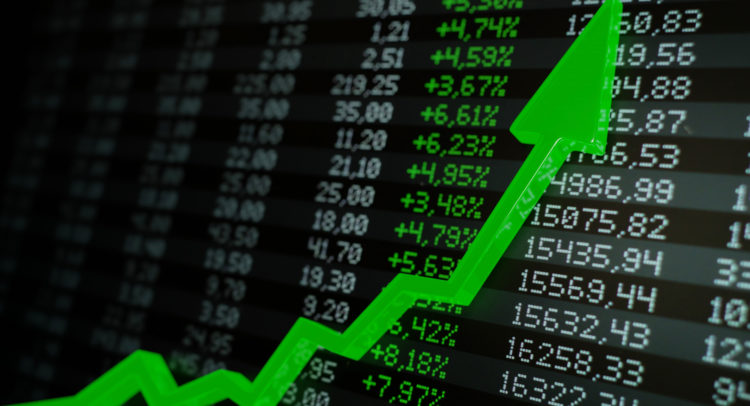

## 1. Importación de Librerías y Descarga de Datos

### 1.1. Importación de Librerías

In [312]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import bs4 as bs
import matplotlib.cm as cm

import math
import requests
import datetime
import random

from scipy.stats import norm


### 1.2. Descarga de Datos

In [194]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

In [195]:
tickers_sp = []

for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers_sp.append(ticker)

In [196]:
tickers_sp = [s.replace('\n', '') for s in tickers_sp]

In [197]:
# Definimos fecha de inicio y final

start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2023, 8, 14)

# Indice SP500

indice = '^GSPC'
data_index = yf.download(indice,start=start,end=end)['Adj Close']

# Acciones del Indice

data = yf.download(tickers_sp, start=start, end=end)['Adj Close']

# Rendimientos de bonos del tesoro de EEUU a 10 años

bond = ['^TNX']
bond10 = yf.download(bond,start=start,end=end)['Adj Close']
bond10_mean = bond10.loc['2022-08-15':'2023-08-09'].mean()/100

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  503 of 503 completed

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
ERROR:yfinance:['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1990-01-01 00:00:00 -> 2023-08-14 00:00:00)')



[*********************100%%**********************]  1 of 1 completed


### 1.3. Limpieza y Modificación de Datos

#### 1.3.1. Concatenación de DataFrames: Unir al Índice con sus Componentes

In [198]:
data_index = data_index.to_frame()
data_index.rename(columns={ 'Adj Close':'^GSPC'}, inplace=True)

In [199]:
# Unimos el Índice con sus acciones

spfull = pd.concat([data, data_index], axis=1)

In [200]:
spfull.head(3)

A  AAL  AAP      AAPL  ABBV  ABC       ABT  ACGL  ACN  \
Date                                                                          
1990-01-02 00:00:00 NaN  NaN  NaN  0.263761   NaN  NaN  1.837212   NaN  NaN   
1990-01-03 00:00:00 NaN  NaN  NaN  0.265531   NaN  NaN  1.843845   NaN  NaN   
1990-01-04 00:00:00 NaN  NaN  NaN  0.266417   NaN  NaN  1.840528   NaN  NaN   

                         ADBE  ...       XEL       XOM      XRAY  XYL  YUM  \
Date                           ...                                           
1990-01-02 00:00:00  1.188340  ...  4.213068  4.068042  0.855866  NaN  NaN   
1990-01-03 00:00:00  1.247023  ...  4.200062  4.027364  0.855866  NaN  NaN   
1990-01-04 00:00:00  1.305707  ...  4.096037  3.986684  0.821631  NaN  NaN   

                     ZBH  ZBRA      ZION  ZTS       ^GSPC  
Date                                                       
1990-01-02 00:00:00  NaN   NaN  1.840072  NaN  359.690002  
1990-01-03 00:00:00  NaN   NaN  1.872930  NaN  358.760010  
1990-01-04 00:00:00  NaN   NaN  1.872930  NaN  355.670013  

[3 rows x 504 columns]

#### 1.3.2. Obtención de Rendimientos en Porcentaje

In [201]:
# Esto es por algun problema que tiene mi PC con el formato de fecha.
# Sin embargo, en algunas computadoras puede ser que sirva sin usar esto.

spfull.index = pd.to_datetime(spfull.index, format='%Y-%m-%d')

# Transformamos a rendimientos porcentuales diarios. P.D. Tomaré los rendimientos a un año.

sp_pct = spfull.loc['2022-08-15':'2023-08-09'].pct_change()

In [202]:
sp_pct.head(3)

A       AAL       AAP      AAPL      ABBV       ABC  \
Date                                                                     
2022-08-15       NaN       NaN       NaN       NaN       NaN       NaN   
2022-08-16 -0.008439  0.011089  0.020796 -0.000924  0.001827  0.012200   
2022-08-17  0.071703 -0.034839  0.001813  0.008785 -0.007787 -0.020503   

                 ABT      ACGL       ACN      ADBE  ...       XEL       XOM  \
Date                                                ...                       
2022-08-15       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2022-08-16  0.001162  0.011066  0.001405 -0.007671  ...  0.004173 -0.009315   
2022-08-17 -0.013211  0.000211 -0.007263 -0.021762  ... -0.001039  0.008091   

                XRAY       XYL       YUM       ZBH      ZBRA      ZION  \
Date                                                                     
2022-08-15       NaN       NaN       NaN       NaN       NaN       NaN   
2022-08-16 -0.021809  0.004445  0.006766 -0.005226 -0.012879  0.005969   
2022-08-17 -0.028004 -0.015775  0.000588 -0.012745 -0.012931  0.001536   

                 ZTS     ^GSPC  
Date                            
2022-08-15       NaN       NaN  
2022-08-16 -0.015248  0.001876  
2022-08-17  0.003900 -0.007238  

[3 rows x 504 columns]

## 2. Creación de Parámetros de Análisis

### 2.1.Covarianza, Varianza y Beta de las Acciones

#### 2.1.1. Covarianza

In [203]:
spcov = sp_pct.loc['2022-08-15':'2023-08-09'].cov()

#### 2.1.2. Varianza del Índice

In [204]:
spvar = sp_pct['^GSPC'].loc['2022-08-15':'2023-08-09'].var()

#### 2.1.3. Beta del Índice y las Acciones

In [205]:
# Obtenemos la beta de todas las acciones

beta = spcov/spvar

In [206]:
# Obtenemos la beta de todas las acciones, pero solamente con relación al índice

beta = beta['^GSPC']

In [207]:
# Convertimos la beta a un DF

beta = beta.to_frame()
beta

^GSPC
A      1.043430
AAL    1.313252
AAP    0.946655
AAPL   1.288240
ABBV   0.348156
...         ...
ZBH    0.791438
ZBRA   1.649012
ZION   1.559689
ZTS    1.040035
^GSPC  1.000000

[504 rows x 1 columns]

### 2.2. Retornos Simples del Índice y las Acciones

#### 2.2.1. Obtenemos el Retorno Simple

In [208]:
# Queremos el retorno simple a un año, así que obtenemos los datos de ese periodo

final = spfull.loc['2023-08-09']
inicial = spfull.loc['2022-08-15']

In [209]:
# Obtenemos el retorno simple en términos porcentuales

retorno_simple = (final / inicial - 1).to_frame()
retorno_simple

0
A     -0.040365
AAL    0.028050
AAP   -0.640764
AAPL   0.033578
ABBV   0.102583
...         ...
ZBH    0.080934
ZBRA  -0.261927
ZION  -0.335979
ZTS    0.095018
^GSPC  0.039694

[504 rows x 1 columns]

### 2.3. Concatenación de las Betas y los Retornos Simples

In [210]:
# Concatenamos los DF

beta_retornos = pd.concat([retorno_simple, beta], axis=1)

In [211]:
# Renombramos las columnas para facilidad de uso

beta_retornos.columns = ['Retornos', 'Betas']

In [212]:
# Agregamos el rendimiento promedio de los bonos a 10 años de EEUU al DF

beta_retornos['TLR'] = bond10_mean

In [213]:
# Agregamos el rendimiento del mercado

beta_retornos['RM'] = beta_retornos.loc['^GSPC', 'Retornos']

### 2.4. Obtención de los Parámetros

#### 2.4.1. CAPM


##### CAPM = TLR+[β*(RM-TLR)]

Donde:

TLR = Tasa Libre de Riesgo (Rendimientos de los bonos a 10 años).

β = Beta invidual de las acciones.

RM = Rendimiento del mercado (S&P500 en este caso.)


In [214]:
# Aplicamos la fórmula para obtener el CAPM

beta_retornos['CAPM'] = beta_retornos['TLR'] + (beta_retornos['Betas']*(beta_retornos['RM']-beta_retornos['TLR']))

#### 2.4.2. Alfa de Jensen

##### α = RA - CAPM

Donde:

RA = Rendimiento Individual de las Acciones.

CAPM = Capital Asset Pricing Model

In [215]:
beta_retornos['Alfa de Jensen'] = beta_retornos['Retornos']-beta_retornos['CAPM']

#### 2.4.3. Ratio de Treynor

#####  RT = (RA-TLR)/β

Donde:

RA = Rendimiento Anual

TLR = Tasa Libre de Riesgo

β = Beta Individual de las Acciones

In [216]:
beta_retornos['Treynor'] = (beta_retornos['Retornos']-beta_retornos['TLR'])/beta_retornos['Betas']

#### 2.4.4. Desviación Estándar Diaria

In [217]:
beta_retornos['Desv. Est. Diaria'] = sp_pct.std()

#### 2.4.5. Desviación Estándar Anual

In [218]:
# Necesitamos obtener la raíz cuadrada de 252 (días que abre la bolsa en un año)

beta_retornos['Desv. Est. Anual'] = beta_retornos['Desv. Est. Diaria'] * math.sqrt(252)

#### 2.4.6. Ratio de Sharpe

##### RS = (RA - TLR) / (σ * sqrt(252))

Donde:

RA = Rendimiento Anual

TLR = Tasa Libre de Riesgo

(σ * sqrt(252)) = Desviación Estándar Anual



In [219]:
beta_retornos['Sharpe'] = (beta_retornos['Retornos']-beta_retornos['TLR'])/beta_retornos['Desv. Est. Anual']

In [220]:
# Por último, veamos el DF de los parámetros

beta_retornos.head(3)

Retornos     Betas       TLR        RM      CAPM  Alfa de Jensen  \
A   -0.040365  1.043430  0.036678  0.039694  0.039825       -0.080190   
AAL  0.028050  1.313252  0.036678  0.039694  0.040639       -0.012589   
AAP -0.640764  0.946655  0.036678  0.039694  0.039533       -0.680297   

      Treynor  Desv. Est. Diaria  Desv. Est. Anual    Sharpe  
A   -0.073836           0.018845          0.299157 -0.257534  
AAL -0.006570           0.025645          0.407095 -0.021195  
AAP -0.715616           0.031309          0.497007 -1.363042

## 3. Elaboración del Portafolio de Inversión

Para el presente ejercicio, el enfoque al momento de crear este portafolio estará dirigido hacia los optimización, utilizando como principales indicadores el Sharpe y la beta de cada acción.

> El ratio de Sharpe nos indica el rendimiento de una acción en función de su riesgo, por ende, es de suma importancia tratar de concentrar en un portafolio aquellas acciones que tienen un Sharpe más grande.



> Por otra parte, la beta nos indica qué tanto se mueve una acción con respecto al mercado de referencia (en este caso el S&P 500). Una beta igual a 1 indica que la acción imita perfectamente los movimientos del mercado, mientras que una beta menor y una beta mayor hablan de menor o mayor volatilidad respecto al índice.\







### 3.1. Filtrado de Acciones: Enfoque de Betas y Sharpes

In [221]:
# Multiplicamos las Betas por los Sharpes, así obtendremos aquellas acciones en las que estos parámetros destacan.

beta_retornos['Sharpe_Beta'] = beta_retornos['Betas'] * beta_retornos['Sharpe']

In [222]:
stocks_sort = beta_retornos.sort_values('Sharpe_Beta', ascending=False)

In [223]:
top10 = stocks_sort.head(10)

top10

Retornos     Betas       TLR        RM      CAPM  Alfa de Jensen  \
NVDA  1.237766  2.121136  0.036678  0.039694  0.043075        1.194691   
RCL   1.433829  1.544496  0.036678  0.039694  0.041336        1.392493   
PHM   0.939391  1.245378  0.036678  0.039694  0.040434        0.898957   
GE    0.807382  0.926123  0.036678  0.039694  0.039471        0.767911   
FICO  0.745177  1.349637  0.036678  0.039694  0.040748        0.704428   
NFLX  0.721729  1.466585  0.036678  0.039694  0.041101        0.680628   
AVGO  0.566997  1.333980  0.036678  0.039694  0.040701        0.526296   
META  0.687268  1.672237  0.036678  0.039694  0.041721        0.645547   
DHI   0.615040  1.115230  0.036678  0.039694  0.040041        0.574998   
CCL   0.612512  2.058505  0.036678  0.039694  0.042886        0.569625   

       Treynor  Desv. Est. Diaria  Desv. Est. Anual    Sharpe  Sharpe_Beta  
NVDA  0.566248           0.036107          0.573173  2.095507     4.444856  
RCL   0.904600           0.032119          0.509881  2.740150     4.232150  
PHM   0.724851           0.021554          0.342164  2.638246     3.285613  
GE    0.832184           0.017652          0.280213  2.750418     2.547225  
FICO  0.524955           0.026962          0.428008  1.655339     2.234107  
NFLX  0.467107           0.029312          0.465316  1.472228     2.159147  
AVGO  0.397547           0.021311          0.338298  1.567611     2.091161  
META  0.389054           0.034132          0.541825  1.200739     2.007920  
DHI   0.518603           0.020766          0.329650  1.754474     1.956643  
CCL   0.279734           0.041260          0.654976  0.879168     1.809771

### 3.2. Matriz de Correlaciones

In [224]:
top_10_lista = top10.index.tolist()

correl = sp_pct[top_10_lista].corr()

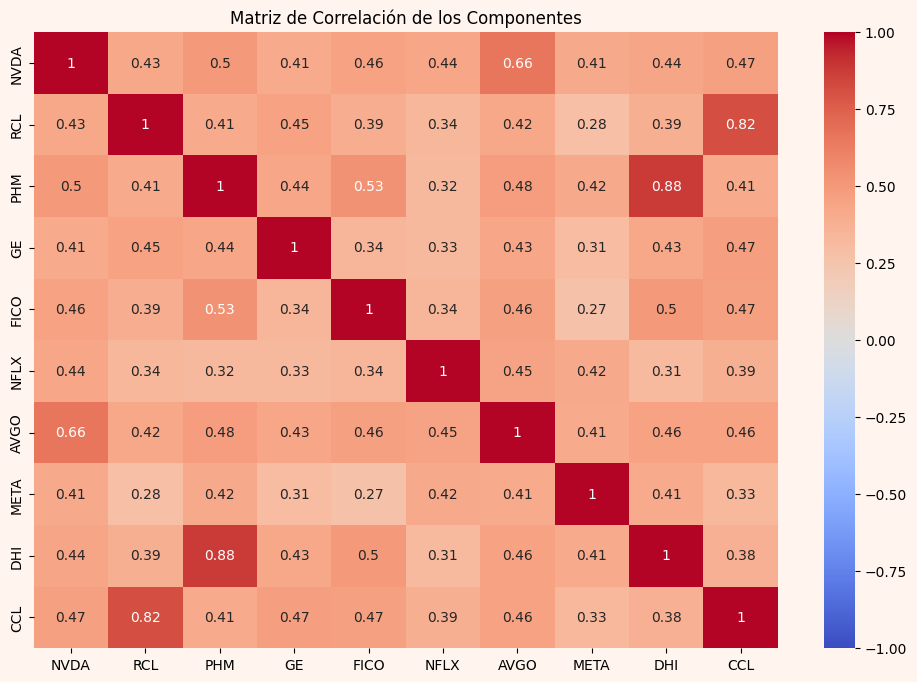

In [225]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Matriz de Correlación de los Componentes')
fig.patch.set_facecolor('seashell')
sns.heatmap(correl, annot=True, cmap='coolwarm',vmin=-1,vmax=1)
plt.show()

### 3.3. Pesos Ideales del Portafolio

In [226]:
# Filtrar el DataFrame por fechas y seleccionar las columnas deseadas
portafolio = spfull.loc['2022-08-15':'2023-08-09', top_10_lista]


In [227]:
#Aqui obtendremos 3 DF: Las posiciones (en términos nominales), los retornos normalizados y los pesos de las acciones en el portafolio

posicion = pd.DataFrame()
normalizado = pd.DataFrame()
pesos = pd.DataFrame()


for stonks in top_10_lista:
    first_adj_close = portafolio[stonks].iloc[0]
    normalizado[stonks + ' Retorno Normalizado'] = portafolio[stonks] / first_adj_close


for stonks in top_10_lista:
    pesos[stonks + ' Peso (%)'] = normalizado[stonks + ' Retorno Normalizado'] * ((100/len(top_10_lista)/100)) #Para distribuir equitativamente el peso del portafolio por si en un futuro son 5, 20, 50 acciones


for stonks in top_10_lista:
    posicion[stonks + ' Posicion'] = pesos[stonks + ' Peso (%)'] * 10000



In [228]:
# Creamos una columna de rendimientos totales, en términos nominales, del portafolio
posicion['Total'] = posicion.sum(axis=1)

#### Figura 3.3.1. $10,000 USD Invertidos en el Portafolio y en el S&P 500

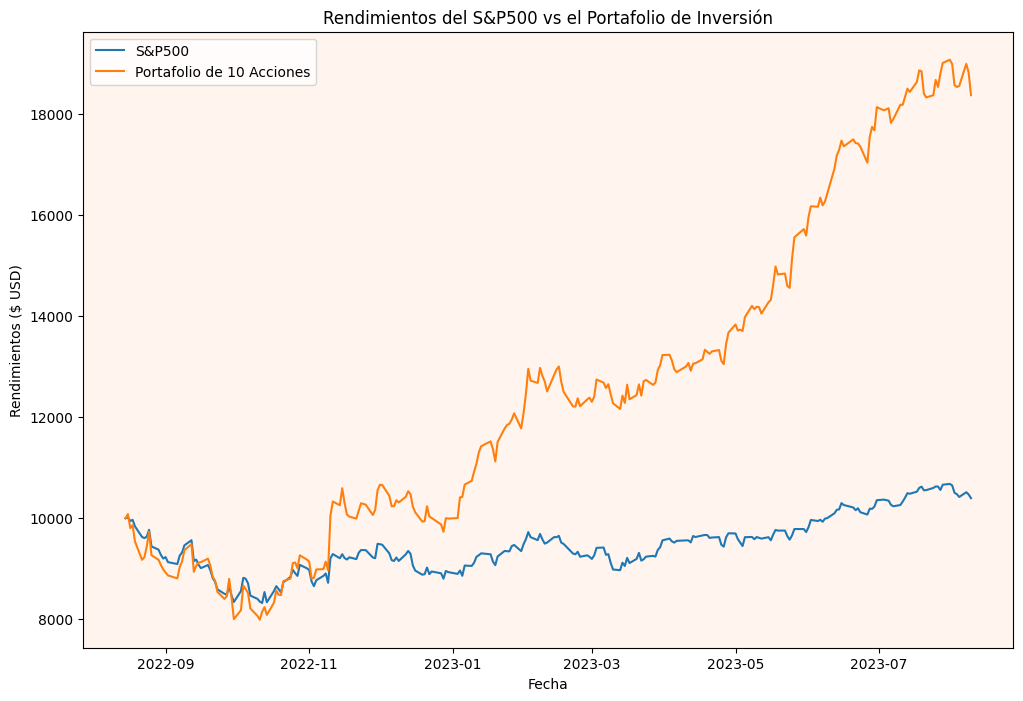

In [229]:
# Elaboramos los DF necesarios para contrastar el portafolio con el índice S&P 500

inicial = '2022-08-15'
final = '2023-08-09'

spfiltrado = spfull.loc[inicial:final]
spindex = spfiltrado['^GSPC']

cierre_ajustado = spindex.iloc[0]
sp_normalizado = spindex/cierre_ajustado
sp_pesos = sp_normalizado*1
sp_posicion = sp_pesos * 10000

# Graficamos

fig, ax = plt.subplots(figsize=(12,8))
ax.set_facecolor('seashell')

ax.plot(sp_posicion.index, sp_posicion, label='S&P500')
ax.plot(posicion.index, posicion['Total'], label='Portafolio de 10 Acciones')

ax.set_xlabel('Fecha')
ax.set_ylabel('Rendimientos ($ USD)')
ax.set_title('Rendimientos del S&P500 vs el Portafolio de Inversión')
ax.legend()


plt.show()

#### Figura 3.3.2. Desempeño de $1,000 Dólares Invertidos en los Componentes del Portafolio vs. el S&P 500

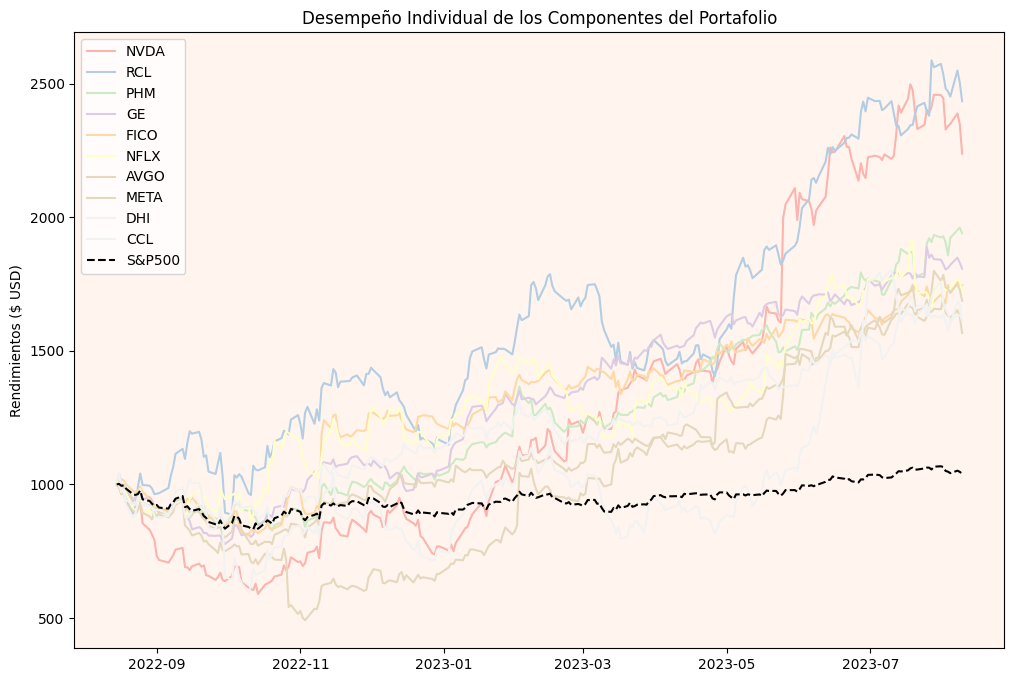

In [230]:
sp_posicion2 = sp_pesos * 1000

plt.figure(figsize=(12, 8))
colors = cm.Pastel1(np.linspace(0, 1, 10))
for i in range(10):
    plt.plot(posicion.iloc[:, i], color=colors[i])

plt.plot(sp_posicion2, label='S&P500', color = 'black', linestyle='--')
ax = plt.subplot()

ax.set_facecolor('seashell')
plt.title('Desempeño Individual de los Componentes del Portafolio')
plt.ylabel('Rendimientos ($ USD)')
labels = top_10_lista + ['S&P500']
plt.legend(labels);

### 3.3.3. Rendimientos Diarios del S&P 500 y de los Componentes del Portafolio

In [231]:
final_portafolio = posicion['Total'][-1]
inicio_portafolio = posicion['Total'][0]

retorno_acumulado = final_portafolio / inicio_portafolio - 1

print(f"El retorno acumulado a un año del portafolio es de {round(retorno_acumulado*100,2)}%")


El retorno acumulado a un año del portafolio es de 83.67%


In [232]:
sp_posicion2.to_frame()

sp_posicion2_rendimiento_diario = sp_posicion2.pct_change()
posicion['Rendimiento Portafolio'] = posicion['Total'].pct_change()

#### Figura 3.3.3. Rendimientos Diarios del S&P 500 y el Portafolio

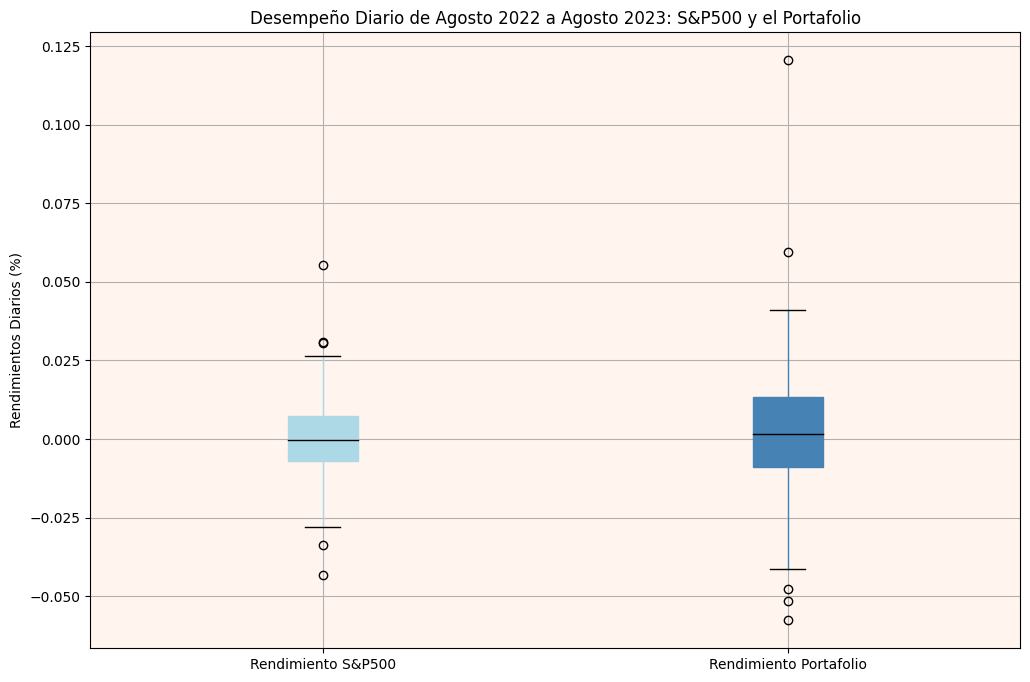

In [233]:
datos_combinados = pd.concat([sp_posicion2_rendimiento_diario.rename('Rendimiento S&P500'), posicion['Rendimiento Portafolio']], axis=1)

plt.figure(figsize=(12, 8))

medianprops = {'color': 'black'}

box_colors = ['lightblue', 'steelblue']

boxplot_elements = datos_combinados.boxplot(patch_artist=True, medianprops=medianprops, return_type='dict')

current_axes = plt.gca()
current_axes.set_facecolor('seashell')

for i, box in enumerate(boxplot_elements['boxes']):
    color = box_colors[i]
    box.set_facecolor(color)
    box.set_edgecolor(color)
    boxplot_elements['whiskers'][i * 2].set_color(color)
    boxplot_elements['whiskers'][i * 2 + 1].set_color(color)

plt.title('Desempeño Diario de Agosto 2022 a Agosto 2023: S&P500 y el Portafolio')
plt.ylabel('Rendimientos Diarios (%)')
plt.show()

### 3.3.4. Desviación Estándar, Retorno Promedio Diario y Ratio de Sharpe del Portafolio

In [234]:
retorno_avg_diario = posicion['Rendimiento Portafolio'].mean()
desv_est_diaria = posicion['Rendimiento Portafolio'].std()

print(f'La desviación estándar diaria de los rendimientos del portafolio es {round(desv_est_diaria, 4)*100}%')
print(f'El rendimiento promedio diario del portafolio es {round(retorno_avg_diario, 4)*100}%')

La desviación estándar diaria de los rendimientos del portafolio es 1.95%
El rendimiento promedio diario del portafolio es 0.27%


In [235]:
sharpe_portafolio = retorno_avg_diario / desv_est_diaria

In [236]:
sharpe_anualizado = np.sqrt(252) * sharpe_portafolio

print(f'El Ratio de Sharpe anualizado del portafolio es {sharpe_anualizado:.2f}')

El Ratio de Sharpe anualizado del portafolio es 2.16


### 3.3.5. Optimización de los Pesos de las Acciones: Sharpe Ideal del Portafolio

In [240]:
lista_stonks = ['NVDA','RCL','PHM','GE','FICO','NFLX','AVGO','META','DHI','CCL']

portafolio = yf.download(lista_stonks, start='2022-08-15',end='2023-08-09')['Adj Close']

total = pd.DataFrame()
posicion = pd.DataFrame()
normalizado = pd.DataFrame()
pesos = pd.DataFrame()


for stonk in lista_stonks:
  primer_cierre_ajustado = portafolio[stonk].iloc[0]
  normalizado[stonk + ' Retorno Normalizado'] = portafolio[stonk]/primer_cierre_ajustado

for stonk in lista_stonks:
  pesos[stonk + ' Posicion'] = normalizado[stonk + ' Retorno Normalizado'] * 0.1

for stonk in lista_stonks:
  posicion[stonk + ' Valor de la Posicion'] = pesos[stonk + ' Posicion'] * 10000


[*********************100%%**********************]  10 of 10 completed


#### Figura 3.3.4. Rendimiento del Portafolio con Ponderación Equitativa

In [241]:
posicion['Total'] = posicion.sum(axis=1)

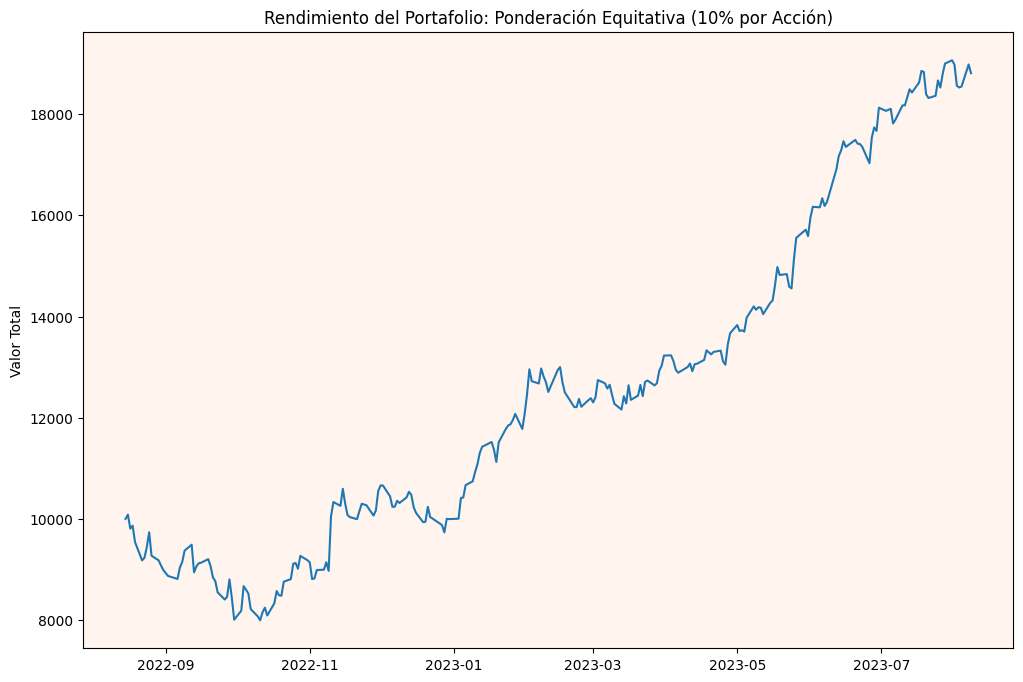

In [244]:
plt.figure(figsize=(12, 8))

plt.plot(posicion['Total'])
ax = plt.subplot()

ax.set_facecolor('seashell')

plt.title('Rendimiento del Portafolio: Ponderación Equitativa (10% por Acción)')
plt.ylabel('Valor Total');

#### Figura 3.3.5. Rendimiento de los Componentes del Portafolio

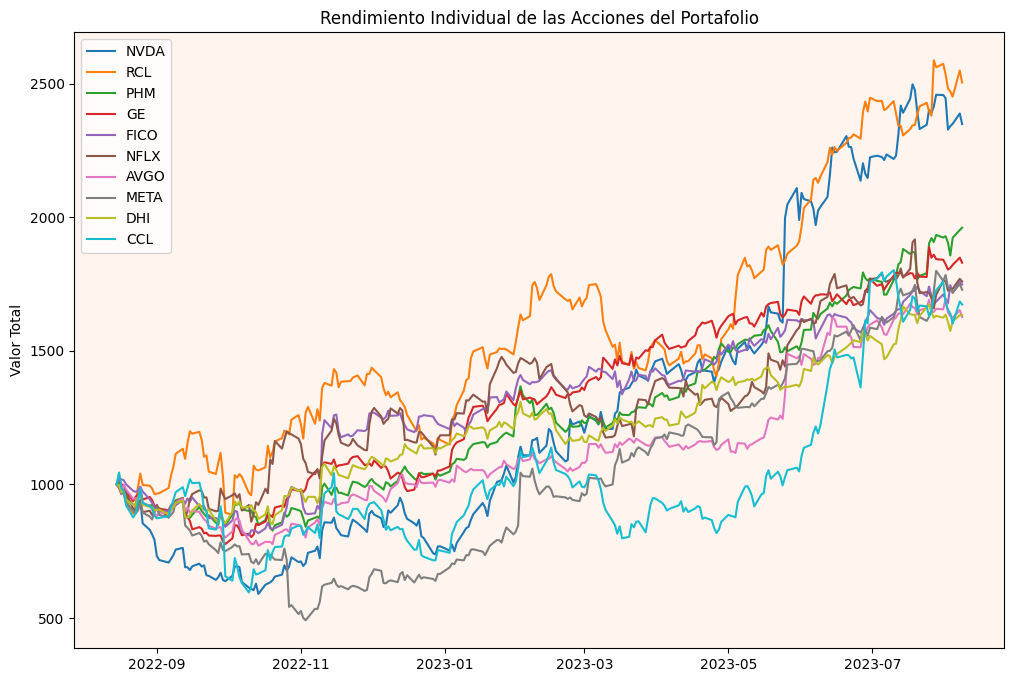

In [246]:
plt.figure(figsize=(12, 8))

plt.plot(posicion.iloc[:,0:10])
ax = plt.subplot()

ax.set_facecolor('seashell')
plt.title('Rendimiento Individual de las Acciones del Portafolio')
plt.ylabel('Valor Total')
plt.legend(lista_stonks);

#### 3.3.6. Rendimiento Diario y Rendimiento Acumulado del Portafolio Equitativamente Ponderado


In [249]:
# Definimos el inicio y el final del portafolio

valor_fin = posicion['Total'][-1]
valor_in = posicion['Total'][0]

# Obtenemos el retorno acumulado del portafolio como porcentaje

portafolio_retorno_acumulado = valor_fin / valor_in - 1

print(f'El retorno acumulado del portafolio durante el periodo es de {round(portafolio_retorno_acumulado*100,2)}%')

El retorno acumulado del portafolio durante el periodo es de 88.13%


In [250]:
# Creamos la columna de retornos diarios

posicion['Retornos Diarios'] = posicion['Total'].pct_change()


In [252]:
media_retorno_diario = posicion['Retornos Diarios'].mean()

print(f'El retorno promedio diario del portafolio es {round(media_retorno_diario*100,2)}%')

El retorno promedio diario del portafolio es 0.28%


In [253]:
# Calculamos la desv. est. de los retornos diarios

std_retornos_diarios = posicion['Retornos Diarios'].std()

print(f'La desviación estándar de los retornos diarios del portafolio es {round(std_retornos_diarios*100,2)}%')

La desviación estándar de los retornos diarios del portafolio es 1.94%


In [254]:
# Calculamos el Sharpe diario y anual del portafolio

sharpe_diario = media_retorno_diario / std_retornos_diarios

sharpe_anual = sharpe_diario * 252**0.5

print(f'El Sharpe diario del portafolio es de {sharpe_diario}')
print(f'El Sharpe anual del portafolio es de {sharpe_anual}')

El Sharpe diario del portafolio es de 0.14197593545785134
El Sharpe anual del portafolio es de 2.2537981042633914


In [255]:
# Creamos un diccionario con los precios de cierre ajustados

stonks_cierre_ajustado = {}

for nombre_stonk, datos_stonk in portafolio.items():
  stonks_cierre_ajustado[nombre_stonk] = datos_stonk


In [257]:
# Convertimos el diccionario a un DataFrame

stonks_cierre_ajustado = pd.DataFrame(stonks_cierre_ajustado)

In [258]:
# Creamos un DF con los retornos diarios del portafolio en pct

retornos_stonks = stonks_cierre_ajustado.pct_change()

#### 3.3.7. Simulación para la Optimización del Portafolio

En esta sección del Jupyter Notebook realizaremos 100 mil simulaciones para lograr encontrar los pesos óptimos para cada acción, con el objetivo de que la distribución logre maximizar la ratio de Sharpe. Es decir, encontraremos un punto donde el retorno del portafolio sea el más alto y el riesgo sea el más bajo posible.


In [259]:
escenarios = 100000

arreglo_pesos = np.zeros((escenarios, len(retornos_stonks.columns)))

print(arreglo_pesos)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [260]:
# Creamos arreglos adicionales para las salidas del modelo

arreglo_retornos = np.zeros(escenarios)
arreglo_vol = np.zeros(escenarios)
arreglo_sharpe = np.zeros(escenarios)

In [264]:
random.seed(42)
np.random.seed(42)

for index in range(escenarios):
  numeros = np.array(np.random.random(10))

  pesitos = numeros / np.sum(numeros)

  arreglo_pesos[index,:] = pesitos

  arreglo_retornos[index] = np.sum(retornos_stonks.mean()*252*pesitos)

  arreglo_vol[index] = np.sqrt(np.dot(pesitos.T,np.dot(retornos_stonks.cov()*252, pesitos)))

  arreglo_sharpe[index] = arreglo_retornos[index] / arreglo_vol[index]


In [265]:
print(f'La primera combinación de pesos tras la simulación es: {arreglo_pesos[0]}')

La primera combinación de pesos tras la simulación es: [0.07200801 0.18278161 0.14073106 0.11509637 0.0299957  0.02999106
 0.01116699 0.16652855 0.11556865 0.13613201]


In [266]:
print(f'El Sharpe del primer portafolio es {arreglo_sharpe[0]}')

El Sharpe del primer portafolio es 2.2045752977041455


In [268]:
print(f'El Sharpe más alto es {arreglo_sharpe.max()}')

El Sharpe más alto es 2.7193057323331318


In [269]:
# Ahora busquemos el indice del portafolio con el Sharpe más elevado

indice_sharpe_max = arreglo_sharpe.argmax()
indice_sharpe_max

69928

In [270]:
# Encontremos el peso óptimo de cada acción

print(lista_stonks)
print(arreglo_pesos[indice_sharpe_max,:])

['NVDA', 'RCL', 'PHM', 'GE', 'FICO', 'NFLX', 'AVGO', 'META', 'DHI', 'CCL']
[0.04473351 0.00699762 0.07524167 0.0464871  0.26810027 0.05588231
 0.06875528 0.01494739 0.16989633 0.24895852]


#### Figura 3.3.7. Visualización del Riesgo-Beneficio de las Diferentes Combinaciones del Portafolio

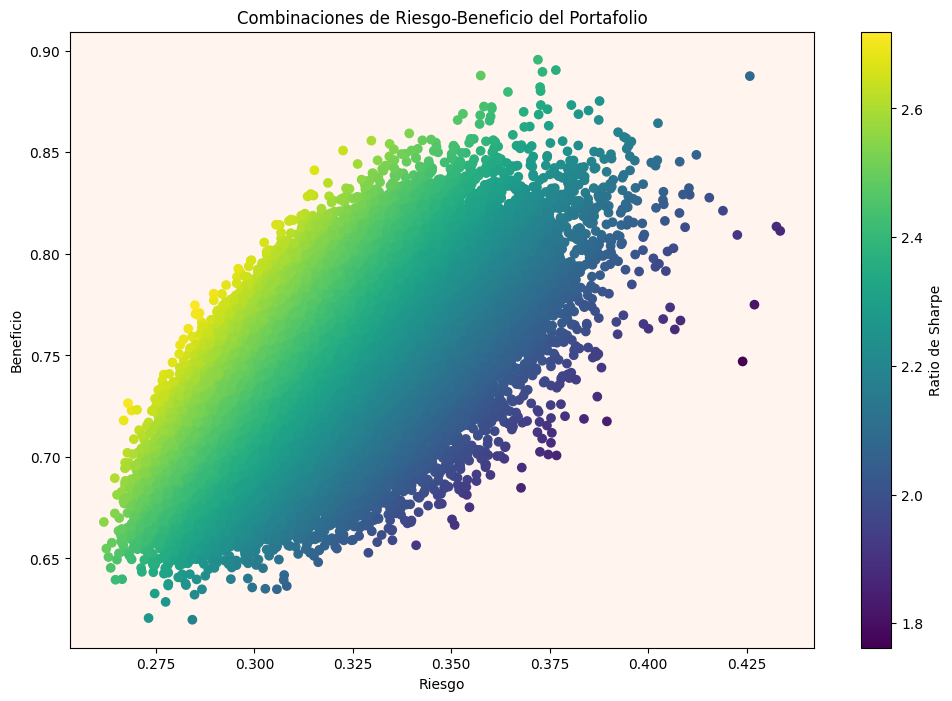

In [288]:
plt.figure(figsize=(12,8))
ax = plt.subplot()

ax.set_facecolor('seashell')
plt.scatter(arreglo_vol,arreglo_retornos, c=arreglo_sharpe,cmap='viridis')

plt.colorbar(label='Ratio de Sharpe')
plt.title('Combinaciones de Riesgo-Beneficio del Portafolio')
plt.xlabel('Riesgo')
plt.ylabel('Beneficio');

#### Figura 3.3.8. Identificación del Punto Óptimo de Riesgo-Beneficio del Portafolio

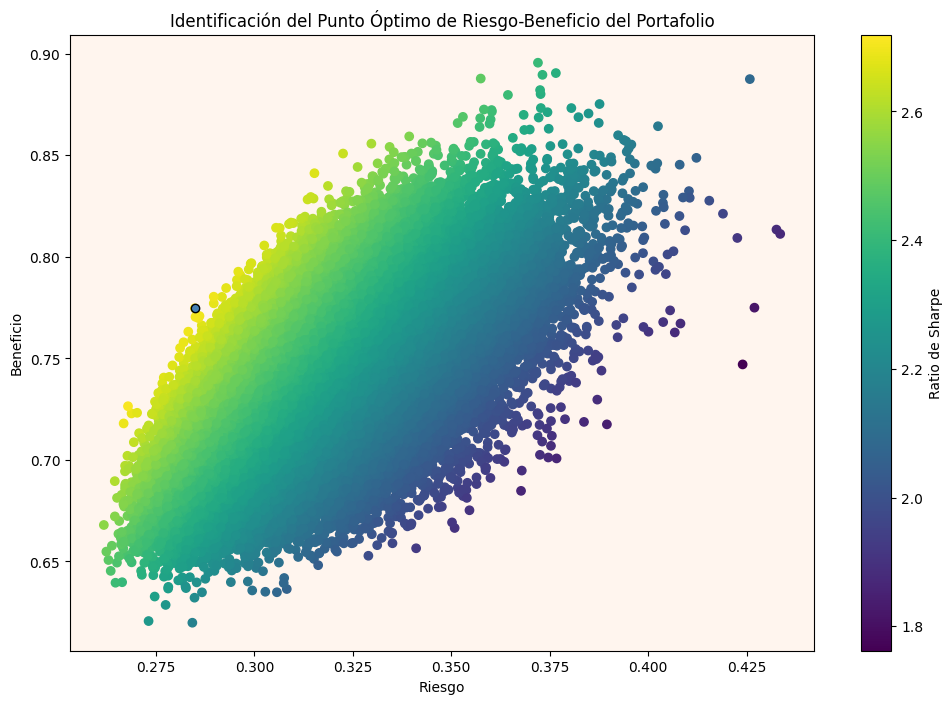

In [289]:
max_riesgo_beneficio = arreglo_retornos[indice_sharpe_max]
max_vol_sharpe = arreglo_vol[indice_sharpe_max]

plt.figure(figsize=(12,8))
ax = plt.subplot()

ax.set_facecolor('seashell')
plt.scatter(arreglo_vol,arreglo_retornos,c=arreglo_sharpe,cmap='viridis')

plt.colorbar(label='Ratio de Sharpe')
plt.title('Identificación del Punto Óptimo de Riesgo-Beneficio del Portafolio')
plt.xlabel('Riesgo')
plt.ylabel('Beneficio')

plt.scatter(max_vol_sharpe,max_riesgo_beneficio, c='steelblue', edgecolors='black');

#### 3.3.8. Construcción del Portafolio: Composición con Pesos Óptimos

In [281]:
nuevos_pesos = pd.DataFrame(arreglo_pesos[indice_sharpe_max,:])

In [284]:
pesos_valor_inicial = nuevos_pesos.iloc[:,0].to_list()

pesos_uno = pd.DataFrame()

for nombre_stonk, peso in zip(lista_stonks, pesos_valor_inicial):
  pesos_uno[nombre_stonk + ' Localización'] = normalizado[nombre_stonk + ' Retorno Normalizado'] * peso

pesos_uno

NVDA Localización  RCL Localización  PHM Localización  \
Date                                                                
2022-08-15           0.044734          0.006998          0.075242   
2022-08-16           0.044374          0.007277          0.075479   
2022-08-17           0.043095          0.006910          0.073700   
2022-08-18           0.044125          0.006902          0.074056   
2022-08-19           0.041953          0.006545          0.071684   
...                       ...               ...               ...   
2023-08-02           0.104137          0.017366          0.143333   
2023-08-03           0.104716          0.017287          0.139714   
2023-08-04           0.105104          0.017155          0.144688   
2023-08-07           0.106838          0.017838          0.146884   
2023-08-08           0.105067          0.017523          0.147535   

            GE Localización  FICO Localización  NFLX Localización  \
Date                                                                
2022-08-15         0.046487           0.268100           0.055882   
2022-08-16         0.047221           0.274505           0.055115   
2022-08-17         0.046551           0.273240           0.054097   
2022-08-18         0.046138           0.272255           0.054998   
2022-08-19         0.045270           0.268100           0.054099   
...                     ...                ...                ...   
2023-08-02         0.083870           0.450049           0.096394   
2023-08-03         0.084162           0.468107           0.096685   
2023-08-04         0.084687           0.460356           0.096820   
2023-08-07         0.085938           0.471440           0.098875   
2023-08-08         0.085054           0.468643           0.098323   

            AVGO Localización  META Localización  DHI Localización  \
Date                                                                 
2022-08-15           0.068755           0.014947          0.169896   
2022-08-16           0.067856           0.014830          0.169444   
2022-08-17           0.066250           0.014448          0.164917   
2022-08-18           0.068693           0.014433          0.165607   
2022-08-19           0.067460           0.013879          0.160110   
...                       ...                ...               ...   
2023-08-02           0.113004           0.025972          0.273137   
2023-08-03           0.112077           0.025880          0.267511   
2023-08-04           0.111655           0.025676          0.273628   
2023-08-07           0.113607           0.026158          0.277502   
2023-08-08           0.111846           0.025834          0.277589   

            CCL Localización  
Date                          
2022-08-15          0.248959  
2022-08-16          0.260116  
2022-08-17          0.245472  
2022-08-18          0.242915  
2022-08-19          0.229432  
...                      ...  
2023-08-02          0.411909  
2023-08-03          0.408190  
2023-08-04          0.398892  
2023-08-07          0.419348  
2023-08-08          0.416558  

[247 rows x 10 columns]

In [285]:
posicion_uno = pd.DataFrame()

for nombre_stonk in lista_stonks:
  posicion_uno[nombre_stonk + ' Valor de Posición'] = pesos_uno[nombre_stonk + ' Localización'] * 10000

posicion_uno['Total'] = posicion_uno.sum(axis=1)

#### Figura 3.3.9. Rendimientos Nominales de los Componentes del Portafolio

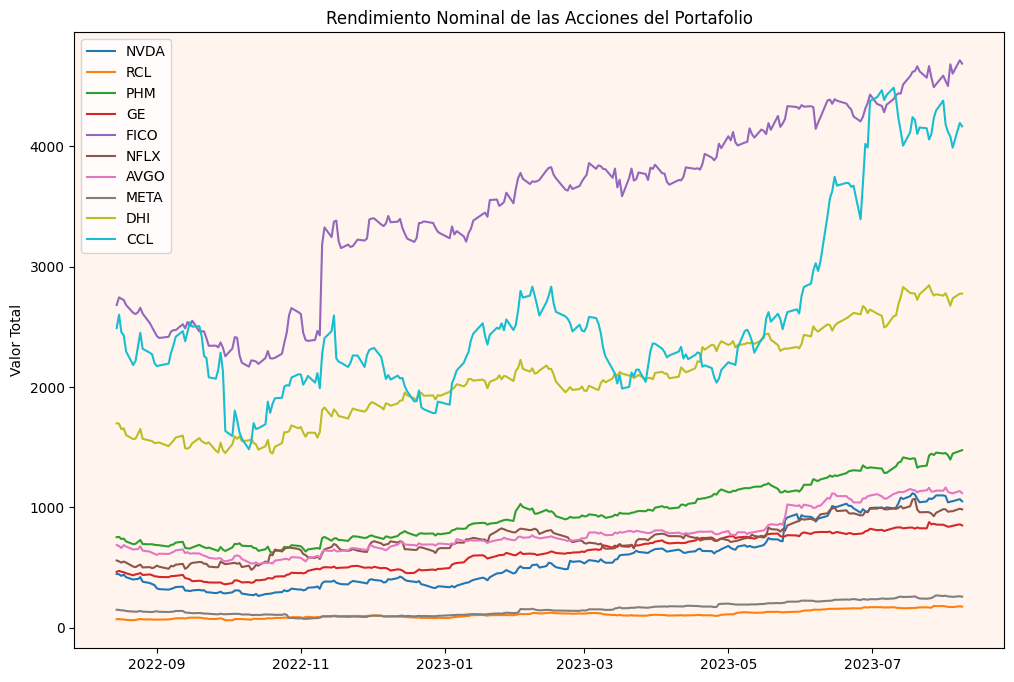

In [287]:
plt.figure(figsize=(12,8))

ax = plt.subplot()

ax.set_facecolor('seashell')
plt.plot(posicion_uno.iloc[:,0:10])

plt.title('Rendimiento Nominal de las Acciones del Portafolio')
plt.ylabel('Valor Total')
plt.legend(lista_stonks);

#### Figura 3.3.10. Rendimiento Nominal del Portafolio: Optimización del Sharpe

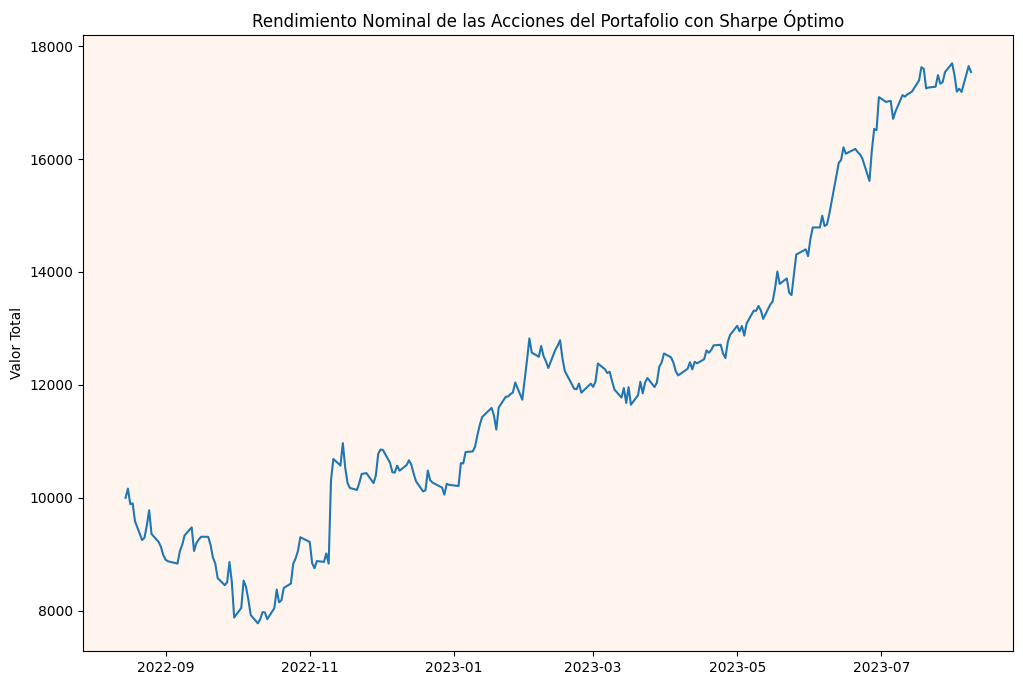

In [292]:
plt.figure(figsize=(12,8))

ax = plt.subplot()

ax.set_facecolor('seashell')
plt.plot(posicion_uno['Total'])

plt.title('Rendimiento Nominal de las Acciones del Portafolio con Sharpe Óptimo')
plt.ylabel('Valor Total');

In [296]:
posicion_uno['Retorno Diario'] = posicion_uno['Total'].pct_change()

print(f"El retorno diario promedio del portafolio es de {round(posicion_uno['Retorno Diario'].mean()*100,2)}%")



El retorno diario promedio del portafolio es de 0.25%


## 4. Simulación de Monte Carlo: Aplicaciones al Portafolio

Como última sección de este pequeño proyecto, utilizaré 10 mil simulaciones de Monte Carlo para estimar un escenario base, optimista y pesimista. Asimismo, partiendo del teorema de los grandes números, utilizaré los estadísticos del portafolio para normalizar la distribución de probabilidad del portafolio, con el objetivo de encontrar los rangos de precios en los que se encontrará el portafolio en un futuro.

### 4.1. Estadísticos y Visualizaciones de la Simulación de Monte Carlo

#### Figura 4.1.1. Retornos Logarítmicos Históricos del Portafolio

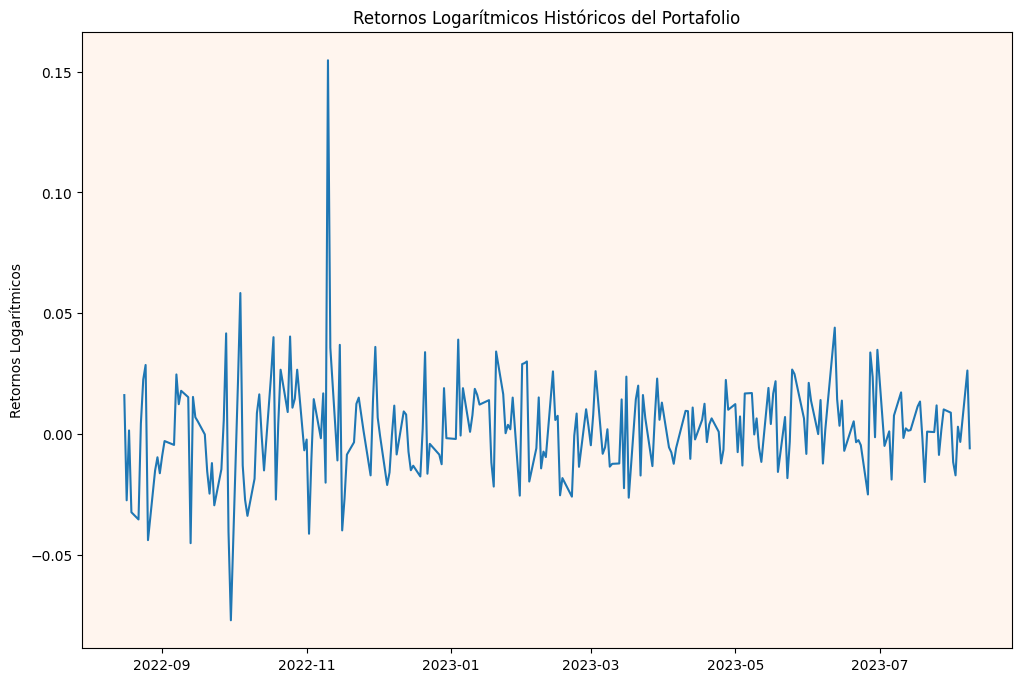

In [300]:
retornos_log = np.log(1 + posicion_uno['Total'].pct_change())

plt.figure(figsize=(12,8))

ax = plt.subplot()

ax.set_facecolor('seashell')
plt.title('Retornos Logarítmicos Históricos del Portafolio')
plt.ylabel("Retornos Logarítmicos")
plt.plot(retornos_log);

#### Figura 4.1.2. Distribución de los Retornos Logarítmicos

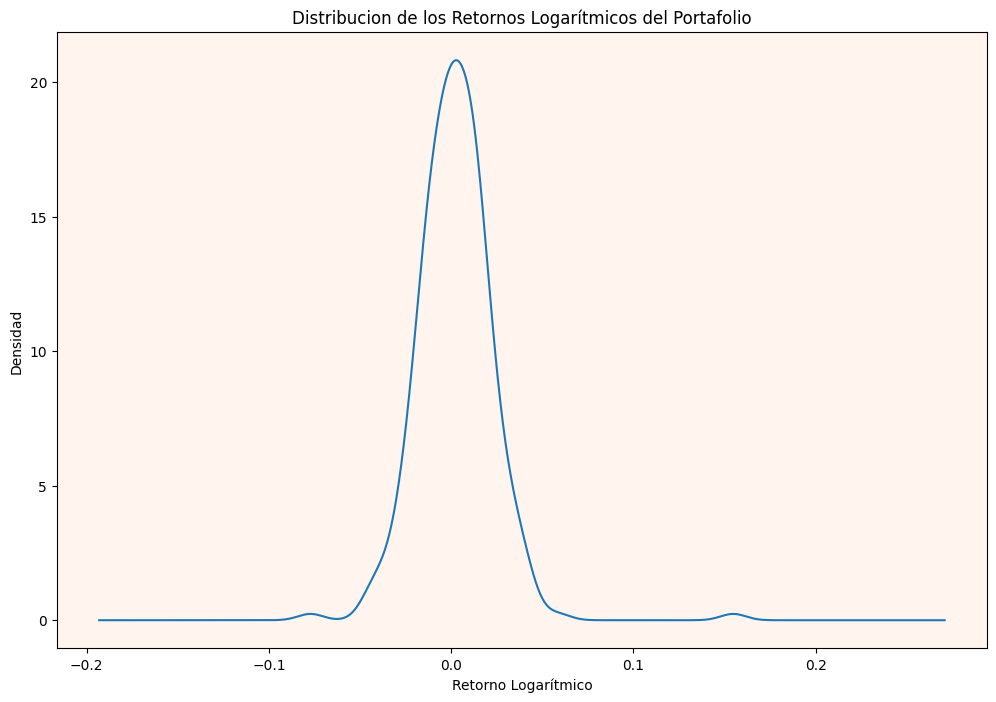

In [309]:
plt.figure(figsize=(12,8))

ax = plt.subplot()

ax.set_facecolor('seashell')
retornos_log.plot(kind='density')


plt.title('Distribucion de los Retornos Logarítmicos del Portafolio')
plt.ylabel('Densidad')
plt.xlabel('Retorno Logarítmico');


In [310]:
# Para la sim. de Monte Carlo primero debemos calcular los estadisticos clave

media = retornos_log.mean()
varianza = retornos_log.var()
STD = retornos_log.std()

In [313]:
numeros_azar = np.random.rand(10000)
normal_num_azar = norm.ppf(numeros_azar)


#### Figura 4.1.3. Distribución de 10,000 Números Generados Aleatoriamente

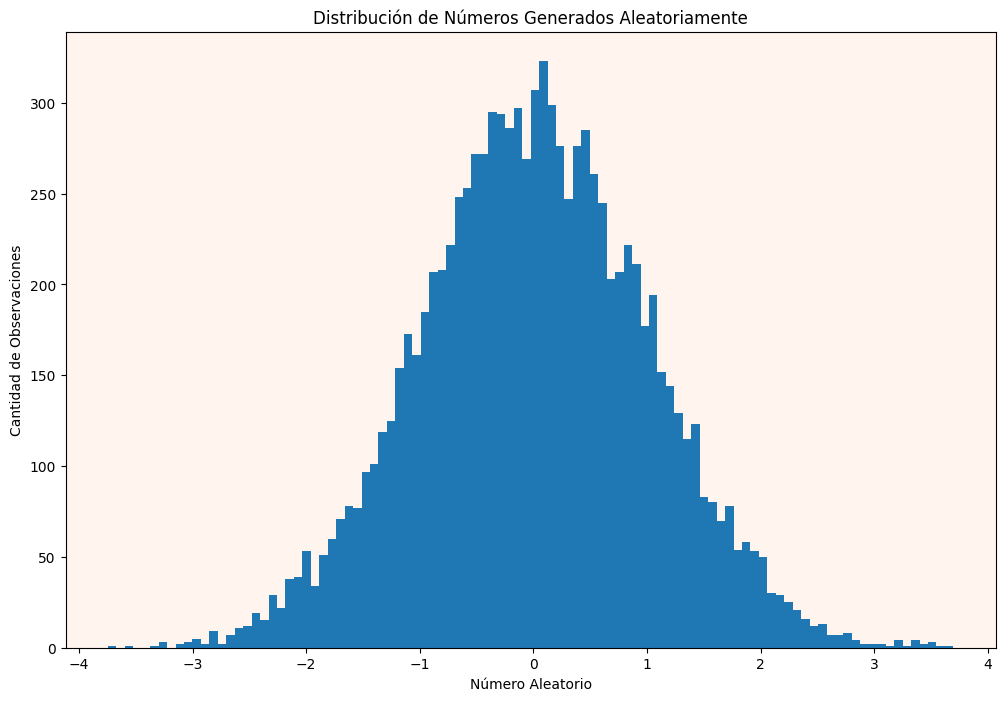

In [319]:
plt.figure(figsize=(12,8))

ax = plt.subplot()

ax.set_facecolor('seashell')
plt.hist(normal_num_azar,bins=100)
plt.title('Distribución de Números Generados Aleatoriamente')
plt.xlabel("Número Aleatorio")
plt.ylabel('Cantidad de Observaciones');


In [326]:
# A partir de aqui generamos lo necesario para la sim. de Monte Carlo

t_intervalos = 252
simu = 10000

retornos_log_sim = STD * norm.ppf(np.random.rand(t_intervalos, simu))
retornos_simples_sim = np.exp(retornos_log_sim)

In [327]:
precio_ultimo = posicion_uno.iloc[-1,-2]

lista_precios = np.zeros_like(retornos_simples_sim)

lista_precios[0] = precio_ultimo

In [328]:
# Aplicamos un bucle para los precios simulados

for t in range(1, t_intervalos):
  lista_precios[t] = lista_precios[t-1] * retornos_simples_sim[t]

#### Figura 4.1.4. Simulación de Monte Carlo: Valor del Portafolio

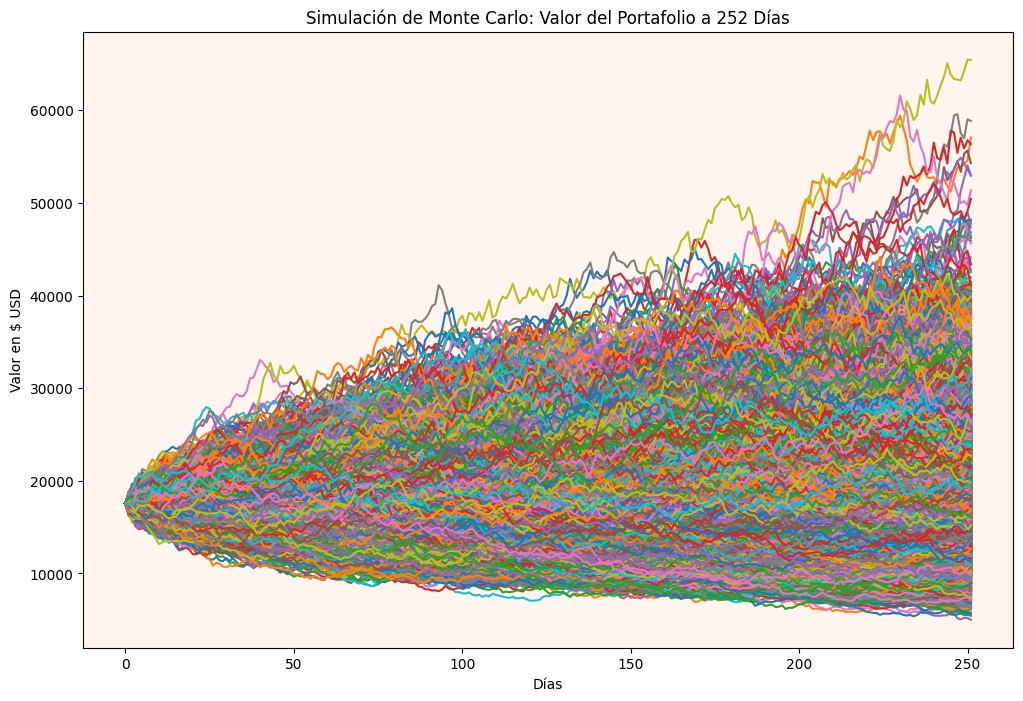

In [330]:
plt.figure(figsize=(12,8))

ax = plt.subplot()

ax.set_facecolor('seashell')
plt.plot(lista_precios)

plt.title(f'Simulación de Monte Carlo: Valor del Portafolio a {t_intervalos} Días')
plt.ylabel('Valor en $ USD')
plt.xlabel('Días');

In [332]:
# Ahora, hagamos la sim. de Monte Carlo con Drift

drift = media - (0.5 * varianza)

retornos_log_drift = retornos_log_sim + drift
retornos_simples_drift = np.exp(retornos_log_drift)


In [333]:
lista_precios_drift = np.zeros_like(retornos_simples_drift)

lista_precios_drift[0] = precio_ultimo


for t in range(1, t_intervalos):
  lista_precios_drift[t] = lista_precios_drift[t-1] * retornos_simples_drift[t]

#### Figura 4.1.5. Simulación de Monte Carlo con Drift: Valor del Portafolio

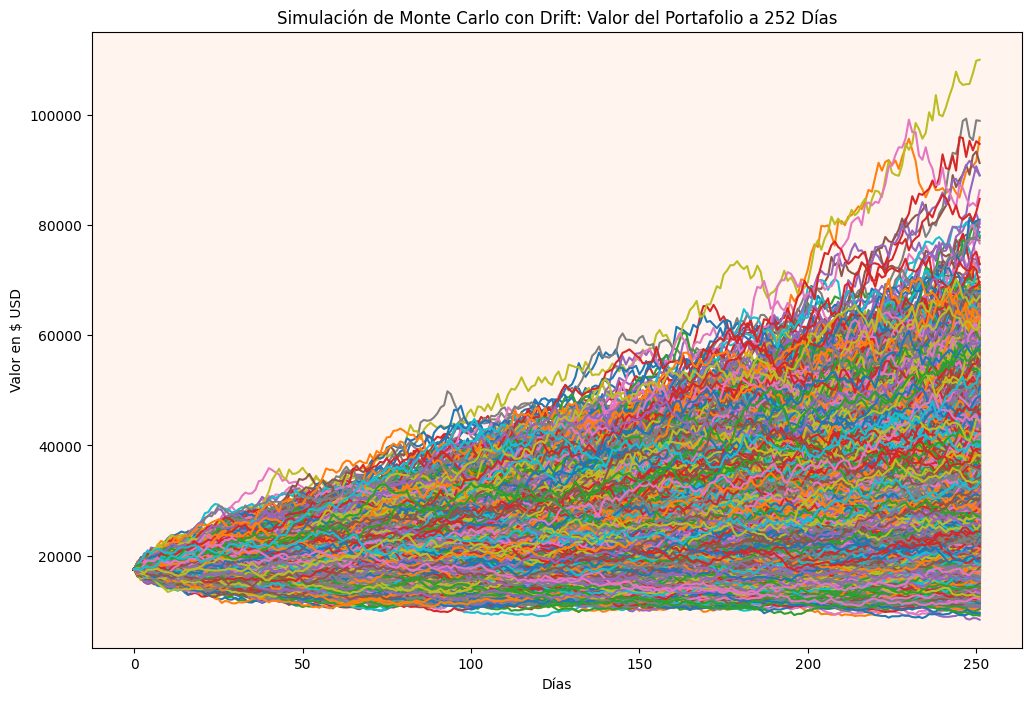

In [342]:
plt.figure(figsize=(12,8))

ax = plt.subplot()

ax.set_facecolor('seashell')
plt.plot(lista_precios_drift)

plt.title(f'Simulación de Monte Carlo con Drift: Valor del Portafolio a {t_intervalos} Días')
plt.ylabel('Valor en $ USD')
plt.xlabel('Días');

### 4.2. Cálculo de Escenarios: Base, Optimista y Pesimista

In [336]:
PeorSim = round(lista_precios_drift[-1].min(),2)
BaseSim = round(lista_precios[-1].mean(),2)
MejorSim = round(lista_precios_drift[-1].max(),2)

In [341]:
print('Mejores y Peores Escenarios\n')

print(f'En el peor de los casos, el valor del portafolio a {t_intervalos} días será de ${PeorSim} dólares')
print(f'En un caso promedio, el valor del portafolio a {t_intervalos} días será de ${BaseSim} dólares')
print(f'En el mejor de los casos, el valor del portafolio a {t_intervalos} días será de ${MejorSim} dólares')

Mejores y Peores Escenarios

En el peor de los casos, el valor del portafolio a 252 días será de $8400.24 dólares
En un caso promedio, el valor del portafolio a 252 días será de $18485.1 dólares
En el mejor de los casos, el valor del portafolio a 252 días será de $109961.49 dólares


In [343]:
# Creamos los intervalos de confianza

media_t_periodos = lista_precios_drift[-1].mean()
std_t_periodos = lista_precios_drift[-1].std()

intervalo_mayor_1std = media_t_periodos + (1 * std_t_periodos)
intervalo_menor_1std = media_t_periodos - (1 * std_t_periodos)

intervalo_mayor_2std = media_t_periodos + (2 * std_t_periodos)
intervalo_menor_2std = media_t_periodos - (2 * std_t_periodos)

In [345]:
print('Intervalos de Confianza\n')
print(f'Existe un 68% de probabilidad de que el precio después de {t_intervalos} días caiga entre ${round(intervalo_menor_1std)} y ${round(intervalo_mayor_1std)}')
print(f'Existe un 95% de probabilidad de que el precio después de {t_intervalos} días caiga entre ${round(intervalo_menor_2std)} y ${round(intervalo_mayor_2std)}')

Intervalos de Confianza

Existe un 68% de probabilidad de que el precio después de 252 días caiga entre $20602 y $41509
Existe un 95% de probabilidad de que el precio después de 252 días caiga entre $10149 y $51963


## Conclusiones

El propósito de este proyecto fue aplicar lo aprendido en la clase de Análisis de Inversión en Acciones, así como diferentes librerías de Python. Asimismo, apliqué dos simulaciones de Monte Carlo para tener cierto margen de certidumbre respecto al comportamiento del portafolio ficticio que creé para este pequeño proyecto.



> No está demás señalar que este proyecto no tiene ninguna intención de promover ninguna clase inversión, y tampoco debería ser tomado como guía de inversión. Es, como señalé anteriormente, un ejercicio para aplicar mis conocimientos teóricos mediante una herramienta tan poderosa como lo es Python.



> Evidentemente, es imposible conocer el futuro, sin embargo, métricas e indicadores como la ratio de Sharpe, las betas y las simulaciones de Monte Carlo nos permiten mitigar el riesgo que tomamos cuando colocamos nuestro dinero en el mercado de capitales. En otras palabras, realizar este tipo de ejercicios, e incluso algunos más exhaustivos, es un deber si se pretende invertir capital propio en los mercados.





